# Experiments on the preprocessing steps

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import time
import pytorch_lightning as pl
import torchvision
import random
from scipy.spatial.distance import cdist, directed_hausdorff
sys.path.append("src")
#from utils import *
from Models.unet import UNet
from Datasets.DSB18 import Nuclie_datamodule
%load_ext autoreload
%autoreload 2

# Sample of the dataset
In spline dist, the data used is the rgb image, with the ground truth contour of the cells

In [2]:
# intialize the dataloaders
datamodule = Nuclie_datamodule()

train_loader = datamodule.train_dataloader()
#val_loader = datamodule.val_dataloader()
batch_x, batch_y = next(iter(train_loader))

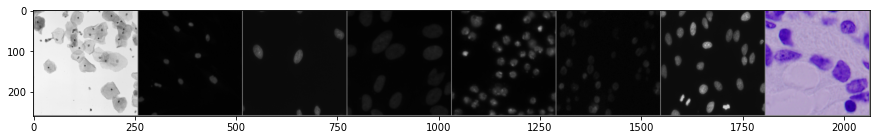

In [3]:
#make grid of the unormalized batch_x using torchvision.utils.make_grid
grid = torchvision.utils.make_grid(batch_x)
# masks = torchvision.utils.make_grid(batch_y)
mean, std = 0.5, 0.5
std_inv = 1 / (std + 1e-7)
mean_inv = -mean * std_inv
grid = torchvision.transforms.Normalize(mean=mean_inv, std=std_inv)(grid)

# and show it
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1,2,0).clamp(0,1))
plt.show()



(256, 256)


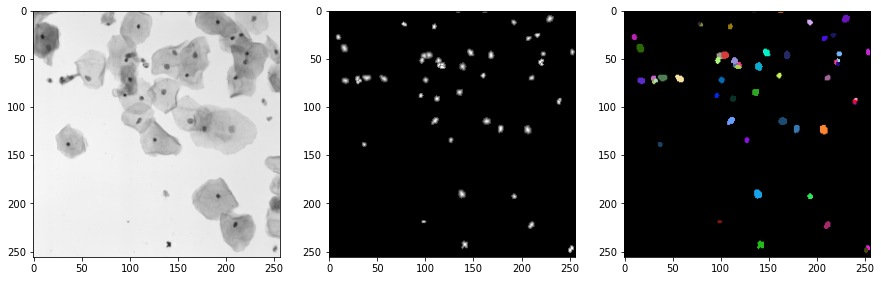

(256, 256)


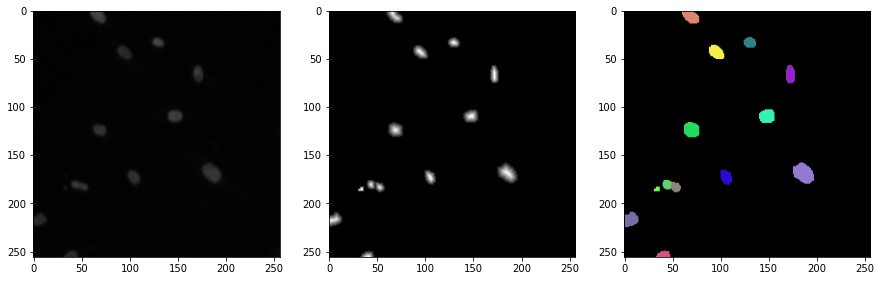

(256, 256)


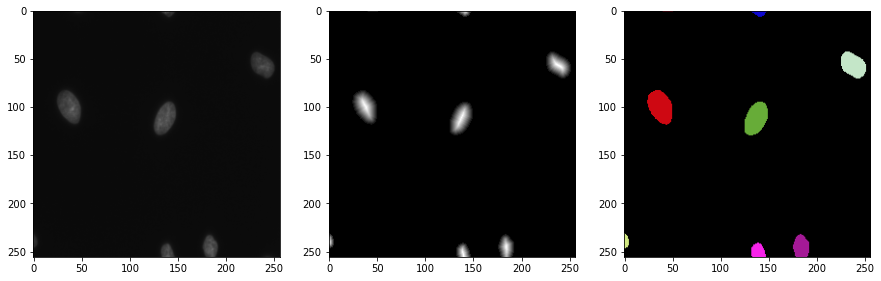

(256, 256)


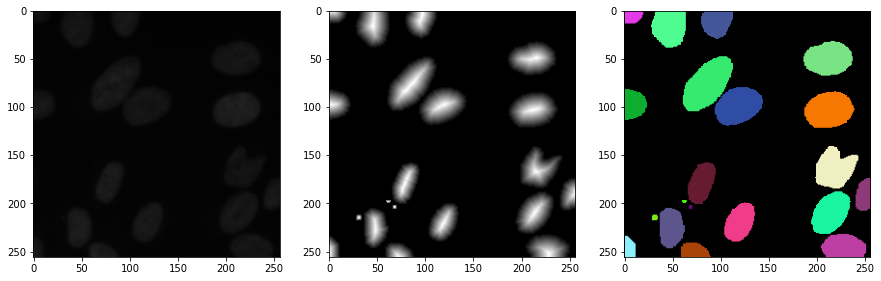

(256, 256)


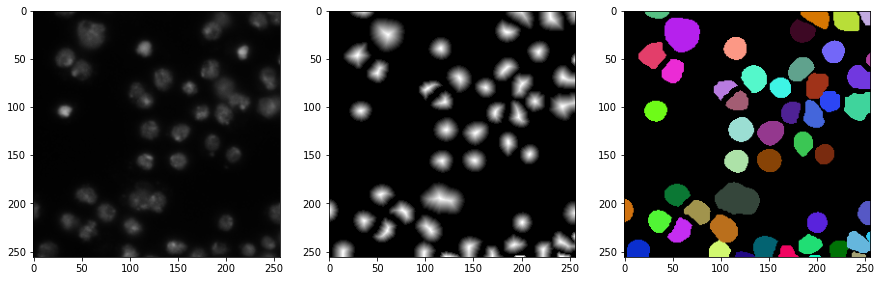

(256, 256)


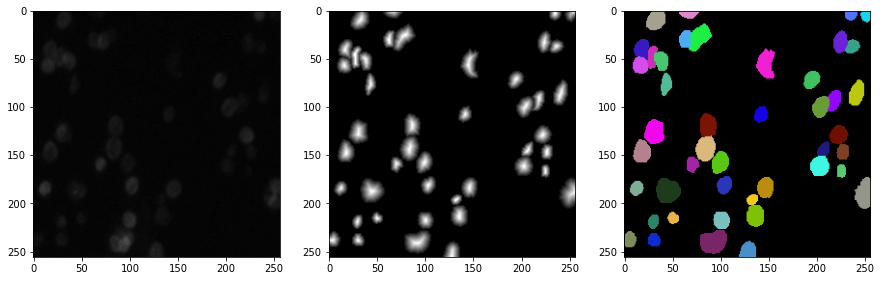

(256, 256)


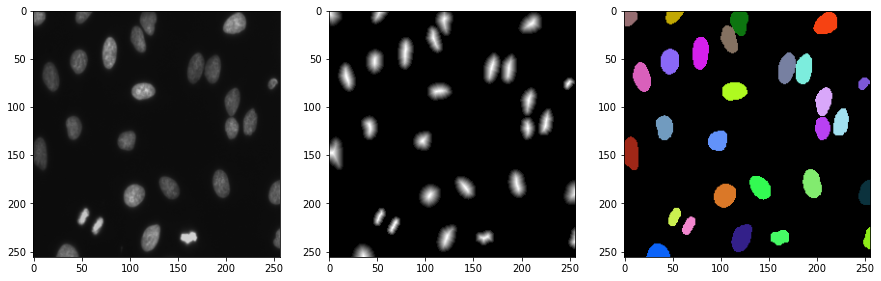

(256, 256)


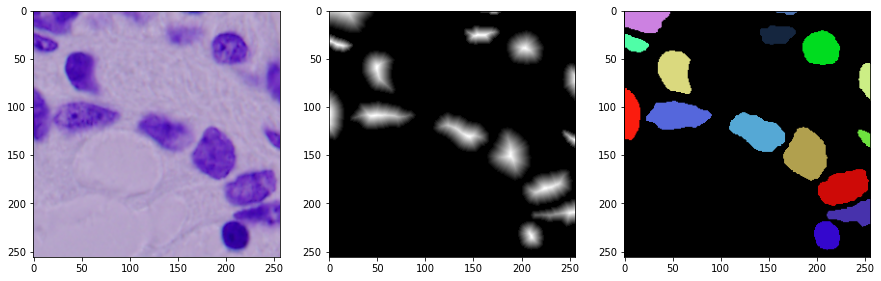

In [4]:
for item in range(len(batch_x)):
    img = batch_x[item]
    mean, std = 0.5, 0.5
    std_inv = 1 / (std + 1e-7)
    mean_inv = -mean * std_inv
    img = torchvision.transforms.Normalize(mean=mean_inv, std=std_inv)(img)

    (objectProbas, overlapProba, objectContours, mask) = batch_y[item].values()
    print(objectProbas.shape)
    plt.figure(figsize=(15, 15))
    plt.subplot(1,3,1)
    plt.imshow(img.permute(1,2,0).clamp(0,1))
    plt.subplot(1,3,2)
    plt.imshow(objectProbas, cmap='gray')
    plt.subplot(1,3,3)
    image = np.zeros((img.shape[1],img.shape[2], 3), dtype=np.uint8)

    for contour in objectContours:
        #plt.plot(contour[:, 0], contour[:, 1], 'r')
        color = np.random.randint(0, 255, size=3)
        color = ( int(color [0]), int(color [1]), int(color [2]))
        cv2.fillPoly(image, pts=[contour], color=color)
    plt.imshow(image)
    plt.show()

# Contour generation from the binary masks

<Figure size 720x720 with 0 Axes>

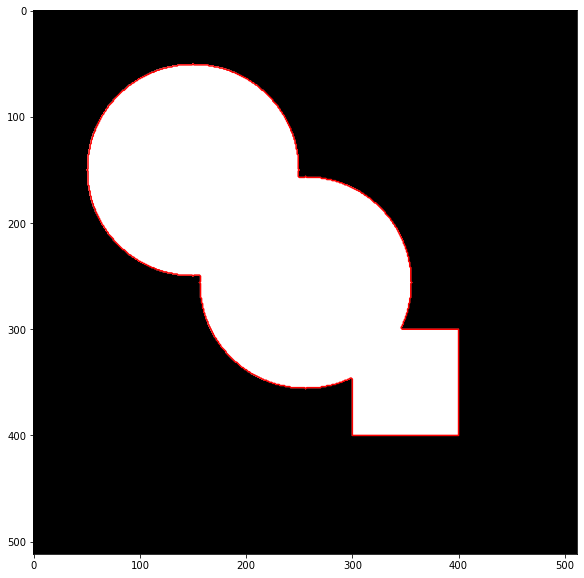

In [5]:

def computeContours(img):
    contours, hierachy = cv2.findContours(img.astype(np.uint8), 
                                  mode=cv2.RETR_LIST, 
                                  method=cv2.CHAIN_APPROX_NONE)
    return contours
# draw a disk in an image using cv2
img = np.zeros((512, 512, 1), np.uint8)
cv2.circle(img, (256, 256), 100, (255, 255, 255), -1)
cv2.circle(img, (150, 150), 100, (255, 255, 255), -1)
#draw a rectangle in an image using cv2
cv2.rectangle(img, (300, 300), (400, 400), (255, 255, 255), -1)

plt.figure(figsize=(10, 10))
contours = computeContours(img)
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.plot(contours[0][:,0,0], contours[0][:,0,1], 'r')

# Generaet object probabilities using binary masks

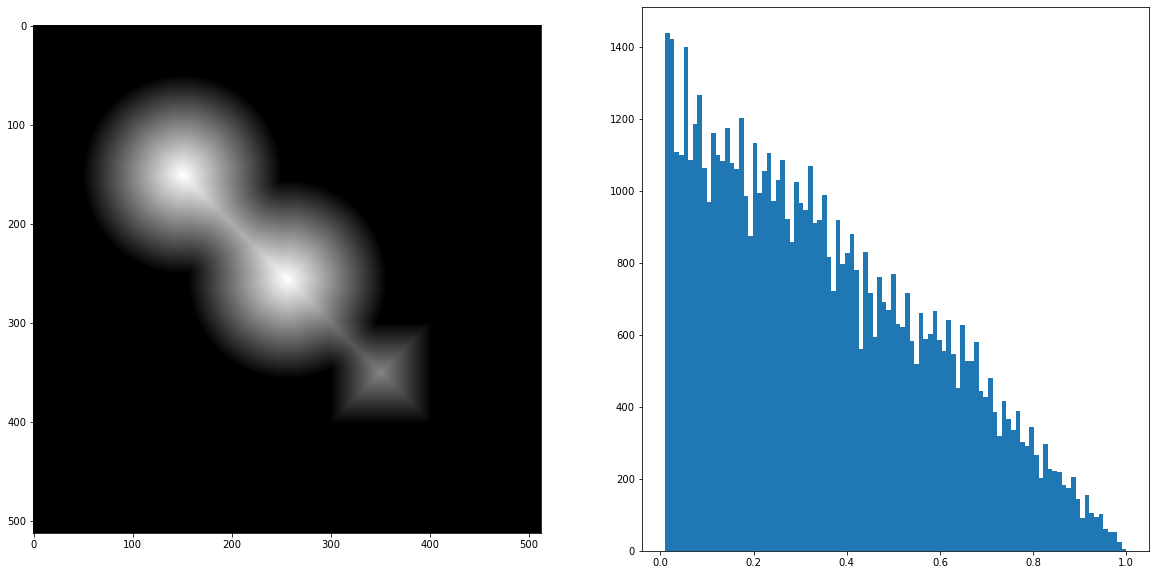

In [6]:
# compute distance transform of img using opencv with the normalized euclidean distance metric
def compute_dist_transform(img):
    dist = cv2.distanceTransform(img, cv2.DIST_L2, 5)
    # normalize the distance transform
    dist = cv2.normalize(dist, None, 0, 1, cv2.NORM_MINMAX)
    return dist

dist = compute_dist_transform(img)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(dist, cmap='gray')
plt.subplot(1, 2, 2)
# show histogram of the distance transform without 0
plt.hist(dist[dist>0].ravel(), bins=100)
plt.show()

C:\Users\mbenimam\AppData\Local\Temp/ipykernel_813520/2356942329.py:8: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(


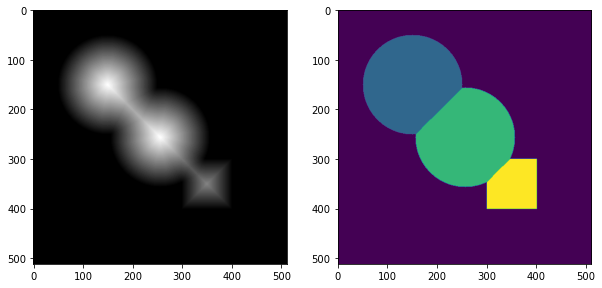

In [7]:
# run watershed on dist
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from skimage import measure

thresh = img.reshape(512, 512)
local_maxi = peak_local_max(
    dist, indices=False, footprint=np.ones((3, 3)), labels=thresh)
markers = measure.label(local_maxi)
labels_ws = watershed(-dist, markers, mask=thresh)

# show markers and segmentation
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.clip(dist,0,1), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(labels_ws)
plt.show()



# let's try every thing on a real exemple


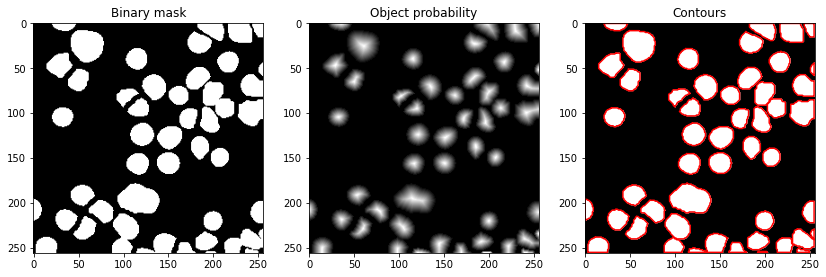

In [9]:
from scipy.optimize import linear_sum_assignment
# mask = np.uint8(batch_y[8].numpy().squeeze()>0)
(objectProbas, overlapProba, objectContours, mask) = batch_y[4].values()
# dist = compute_dist_transform(mask)
dist = objectProbas
# show image with historgram and fix the size of the histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
ax1.imshow(mask, cmap='gray')
ax1.set_title('Binary mask')
# show 
ax2.imshow(dist, cmap='gray')
ax2.set_title('Object probability')


#contours = computeContours(mask)
contours = objectContours
ax3.imshow(mask, cmap='gray')
for contour in contours:
    ax3.plot(contour[:,0], contour[:,1], 'r')
ax3.set_title('Contours')

plt.show()


# Compute the distance bettween two contours


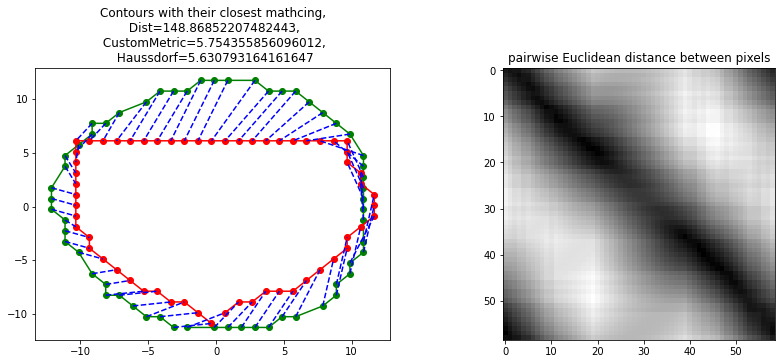

148.86852207482443

In [10]:
def computeDistanceBetweenInstance2(instance1, instance2, plot=False):
    # show two images containing contours 1 and 2
    contour1, contour2 = instance1, instance2
    sampling_factor = min(len(contour1), len(contour2))

    # The two contours must have the same length
    index = np.floor(np.linspace(0, len(contour1)-1, sampling_factor)).astype(int)
    contour1 = contour1[index]

    index = np.floor(np.linspace(0, len(contour2)-1, sampling_factor)).astype(int)
    contour2 = contour2[index]
    #print(f"contour1: {len(contour1)}, contour2: {len(contour2)}")

    # translate the contours to the same origin
    contour1 = contour1 - contour1.mean(0)
    contour2 = contour2 - contour2.mean(0)
    # compute the bounding box of the contours

    # we must match every pixel of the contour to the corresponding pixel of the other contour
    # we use the euclidean distance to compute the distance between the contour pixels

    cost = cdist(contour1, contour2, metric='euclidean')
    #scikit_dist_min = scikit_dist.min(axis=1)
    rowId, colId = linear_sum_assignment(cost)
    distance = cost[rowId, colId].sum()

   # show the distance matrix
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))



        ax1.plot(contour1[:,0], contour1[:,1], 'go-', label='contour1')
        ax1.plot(contour2[:,0], contour2[:,1], 'ro-', label='contour2')
        ax1.set_title(f"Contours with their closest mathcing,\n Dist={distance},\n CustomMetric={cost[rowId, colId].max()},\n Haussdorf={directed_hausdorff(contour1, contour2)[0]}")
        # plot a line for each couple of pixels of index i and j in the indeces returned by scikit_dist_min_args
        for i, j in zip(rowId, colId):
            ax1.plot([contour1[i,0], contour2[i,0]], [contour1[i,1], contour2[i,1]], 'b--')

        ax2.imshow(cost, cmap='gray')
        ax2.set_title('pairwise Euclidean distance between pixels')
        plt.show()


    return distance

computeDistanceBetweenInstance2(contours[2], contours[4], plot=True)

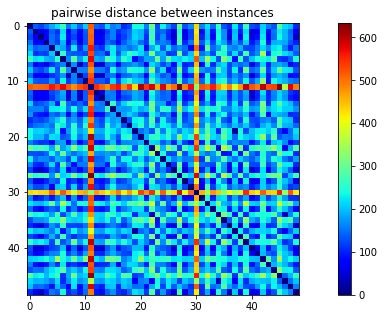

In [12]:
import copy
# compute the distance matrix using the euclidean distance between pairs of instances
contours2 = copy.deepcopy(contours) # just a toy exemple of prediction
# contours1_bis = contours1.reshape(contours1.shape(0), -1)
# contours2_bis = contours2.reshape(contours2.shape(0), -1)
# dist = pairwise(contours1_bis, contours2_bis, metric=computeDistanceBetweenInstance, n_jobs=1)
dist_mat = np.zeros((len(contours), len(contours2)))

for i in range(len(contours)):
    for j in range(len(contours2)):
        dist_mat[i,j] = computeDistanceBetweenInstance2(contours[i], contours2[j], plot=False)

# show the distance matrix
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig = plt.figure(figsize=(14, 5))
plt.imshow(dist_mat, cmap='jet')
plt.colorbar()
plt.title('pairwise distance between instances')
plt.show()


In [13]:
dist_mat.argmin(axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64)